# Simple Neural Networks

First, we create a simpler CNN architecture. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import pickle
from src.utils import *
from src.data import DataGenerator
from src.cnn import *
from collections import OrderedDict

# Convolutional Neural Network

In [5]:
# Load Data
us_temp_data = xr.open_mfdataset('../data/us_temperature.nc').t2m
us_rain_data = xr.open_mfdataset('../data/us_precipitation.nc').tp

us_temp_data = us_temp_data[7:]
assert np.all(us_rain_data.time == us_temp_data.time)
ds = xr.merge([us_temp_data, us_rain_data])

# Split into train and test data
ds_train = normalize(ds.sel(time=slice('2016')))
ds_test = normalize(ds.sel(time=slice('11/01/2018', '12/31/2018')))
ds_test_data = normalize(ds.sel(time=slice('2017', '2018')))
valid = normalize(ds.sel(time=slice('2017', '2018')))

_, nlat, nlon = ds_train.t2m.shape

In [6]:
ds_train

<xarray.Dataset>
Dimensions:  (lon: 13, lat: 7, time: 333113)
Coordinates:
  * lon      (lon) float64 230.6 236.2 241.9 247.5 ... 281.2 286.9 292.5 298.1
  * lat      (lat) float64 19.69 25.31 30.94 36.56 42.19 47.81 53.44
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2016-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(333113, 7, 13), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(333113, 7, 13), meta=np.ndarray>

In [7]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'t2m': None, 'tp': None})

bs=32
lead_time=30*24

In [8]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)
dg_test_data = DataGenerator(ds_test_data, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [6]:
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (nlat, nlon, 2))

cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 13, 2)]        0         
                                                                 
 periodic_conv2d (PeriodicCo  (None, 7, 13, 64)        3264      
 nv2D)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 13, 64)         0         
                                                                 
 periodic_conv2d_1 (Periodic  (None, 7, 13, 64)        102464    
 Conv2D)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 13, 64)         0         
                                                                 
 periodic_conv2d_2 (Periodic  (None, 7, 13, 64)        102464

In [7]:
cnn.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=2,
                        verbose=1, 
                        mode='auto'
                    )]
         )

Epoch 1/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.7734 - val_loss: 0.8182
Epoch 2/100
10113/10113 [==============================] - 32s 3ms/step - loss: 0.7375 - val_loss: 0.8252
Epoch 3/100
10113/10113 [==============================] - 32s 3ms/step - loss: 0.7290 - val_loss: 0.8150
Epoch 4/100
10113/10113 [==============================] - 32s 3ms/step - loss: 0.7238 - val_loss: 0.7972
Epoch 5/100
10113/10113 [==============================] - 32s 3ms/step - loss: 0.7197 - val_loss: 0.8026
Epoch 6/100
10113/10113 [==============================] - 32s 3ms/step - loss: 0.7160 - val_loss: 0.8005
Epoch 6: early stopping


In [8]:
compute_weighted_rmse(create_predictions(cnn, dg_test_data), valid).compute()

525/525 [==============================] - 1s 1ms/step


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.4679
    tp       float64 0.6112

In [9]:
fc = create_predictions(cnn, dg_test)

24/24 [==============================] - 0s 2ms/step


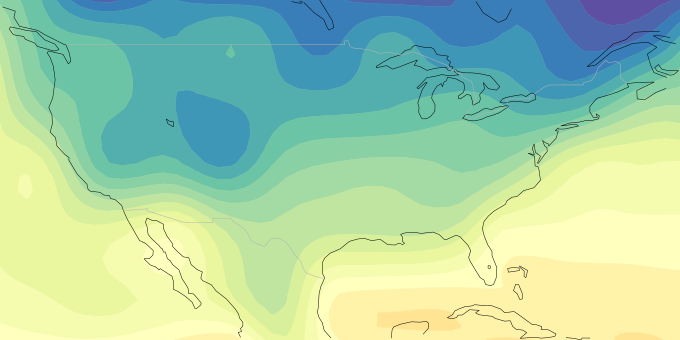

In [10]:
plot_temp(normalize(fc.t2m[0]))

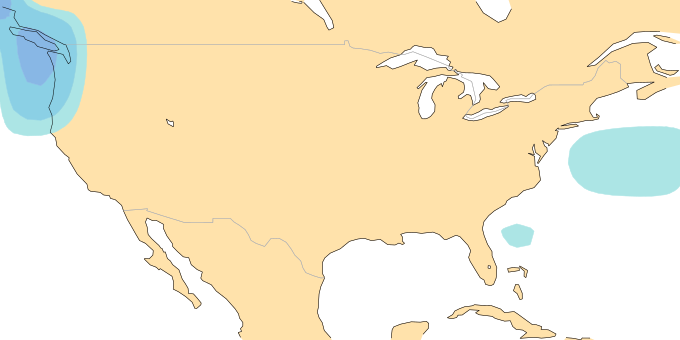

In [11]:
plot_rain(normalize(fc.tp[0]))

In [12]:
cnn.save_weights('../models/cnn.h5')
# cnn.load_weights('../models/cnn.h5')

In [13]:
fc.t2m[-720:].to_netcdf('../data/us_temperature_cnn_forecast.nc')
fc.tp[-720:].to_netcdf('../data/us_precipitation_cnn_forecast.nc')

## Artificial Neural Network

The other model is an Artificial Neural Network with five hidden layers consisting of eight neurons each, with a tansigmoid transfer function. 

In [14]:
from ann import *

In [15]:
# TODO: Create Data Generator 
ann = build_ann((nlat, nlon, 2))
ann.compile(keras.optimizers.Adam(1e-4), 'mse')

In [16]:
# TODO: Create and Train Model 
ann.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=2,
                        verbose=1, 
                        mode='auto'
                    )]
         )

Epoch 1/100
10113/10113 [==============================] - 36s 3ms/step - loss: 1.4206 - val_loss: 1.2100
Epoch 2/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9991 - val_loss: 1.0322
Epoch 3/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9683 - val_loss: 1.0164
Epoch 4/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9560 - val_loss: 1.0025
Epoch 5/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9475 - val_loss: 0.9958
Epoch 6/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9419 - val_loss: 0.9910
Epoch 7/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9381 - val_loss: 0.9861
Epoch 8/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9351 - val_loss: 0.9831
Epoch 9/100
10113/10113 [==============================] - 35s 3ms/step - loss: 0.9328 - val_loss: 0.9822
Epoch 10/100
10113/10113 [====================

In [17]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, None, 2)     6         
                                                                 
 dense_1 (Dense)             (None, None, None, 8)     24        
                                                                 
 dense_2 (Dense)             (None, None, None, 8)     72        
                                                                 
 dense_3 (Dense)             (None, None, None, 8)     72        
                                                                 
 dense_4 (Dense)             (None, None, None, 8)     72        
                                                                 
 dense_5 (Dense)             (None, None, None, 8)     72        
                                                                 
 periodic_conv2d_5 (Periodic  (None, None, None, 2)    4

In [18]:
# TODO: Create Predictions
compute_weighted_rmse(create_predictions(ann, dg_test_data), valid).compute()


525/525 [==============================] - 1s 2ms/step


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.3851
    tp       float64 0.5965

In [19]:
fc = create_predictions(ann, dg_test)

24/24 [==============================] - 0s 2ms/step


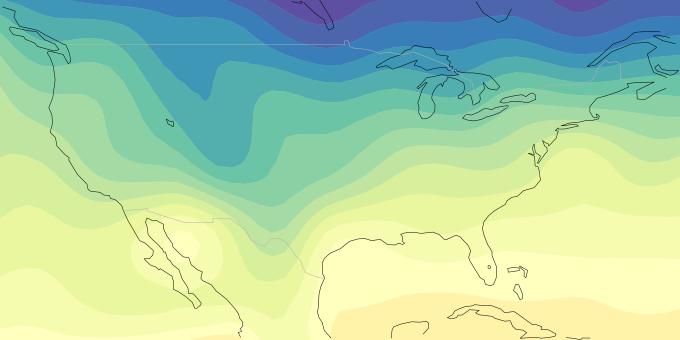

In [20]:
# TODO: Visualize Results
plot_temp(normalize(fc.t2m[0]))

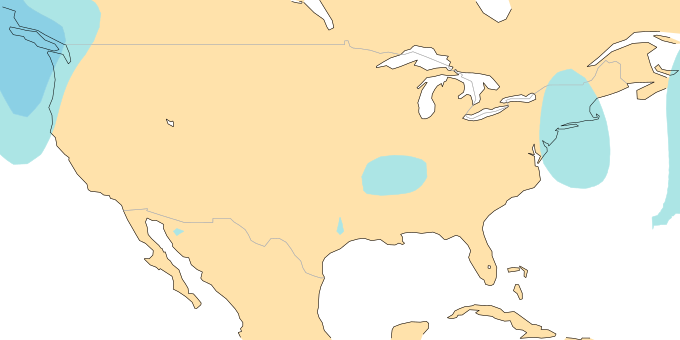

In [21]:
plot_rain(normalize(fc.tp[0]))

In [22]:
ann.save_weights('../models/ann.h5')
# ann.load_weights('../models/ann.h5')

In [23]:
fc.t2m[-720:].to_netcdf('../data/us_temperature_ann_forecast.nc')
fc.tp[-720:].to_netcdf('../data/us_precipitation_ann_forecast.nc')